In [1]:
import os
print("PYTHONPATH is:", os.environ.get('PYTHONPATH', 'Not found'))


PYTHONPATH is: :/autofs/space/bal_004/users/jd1677/neurite-sandbox/:/autofs/space/bal_004/users/jd1677/voxelmorph-sandbox:/autofs/space/bal_004/users/jd1677/neurite


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
import numpy as np
import os
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
# from neurite.tf.utils.augment import labels_to_labels

# import ne.keras as nke
import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
# from voxelmorph.tf.networks import Unet

# tf.keras.utils.disable_interactive_logging()

# tf.get_logger().setLevel('ERROR')

nb_features=64
log_dir='logs_feta_mom_brain_params_'+str(nb_features)
models_dir='models_feta_mom_brain_params_'+str(nb_features)
data_dir = 'feta_2d/'
initial_epoch=36100
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
nb_labels=8
dimx=256
dimy=256



batch_size=2
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
lr = 1e-4
lr_lin = 1e-4
nb_levels=5
conv_size=3
num_epochs=50000
num_bg_labels=16
warp_fwhm_min=10
warp_fwhm_max=20
warp_min_shapes=10
warp_max_shapes=50
in_shape=(dimx,dimy)
bg_brain = True
labels_in=[i for i in range(num_bg_labels+nb_labels)]
labels_in_unique = np.unique(labels_in).astype(int)
image_fwhm_min=200
image_fwhm_max=300
aff_shift=32
aff_scale=0.2
aff_shear=0.1
bias_min=0.01
bias_max=0.2
zero_background=0.1

kwargs_shapes = {
'num_label': num_bg_labels,
'nb_labels':nb_labels,
'warp_min': warp_min_shapes,
'warp_max': warp_max_shapes,
'image_fwhm_max':image_fwhm_max,
'image_fwhm_min':image_fwhm_min,
'zero_background':zero_background
}

gen_arg = {
    'in_shape': in_shape,
    'labels_in': labels_in,
    'labels_out': {i: 1 if i > 0 and i < nb_labels else 0 for i in range(num_bg_labels+nb_labels)},  
    'warp_min': warp_min,
    'one_hot':True,
    'axes_flip':True,
    'axes_swap':True,
    'warp_max': warp_max,
    'aff_shift':aff_shift,
    'aff_rotate':180,
    'aff_scale':aff_scale,
    'aff_shear':aff_shear,
    'bias_min':bias_min,
    'bias_max':bias_max,
    'bias_func':tf.exp,
    'zero_background':zero_background
}

weights_saver = PeriodicWeightsSaver(filepath=models_dir, save_freq=50)  # Save weights every 5 epochs

TB_callback = CustomTensorBoard(
    base_log_dir=log_dir,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

    
def load_data(data_dir):
    
    subject_dirs = [d for d in os.listdir(data_dir) if d.startswith('sub-')]
    seg_image_filenames = []
    real_image_filenames = []
    fetal_data = []  # List to store fetal images
    fetal_segmentation_masks = []  # List to store fetal segmentation masks
    
    for subject_dir in subject_dirs:
        subject_prefix = subject_dir
    
        # Search for the T2-weighted image and segmented brain image with flexible naming patterns
        t2w_path = None
        dseg_path = None
        # print(os.path.join(data_dir, subject_prefix))
        for filename in os.listdir(os.path.join(data_dir, subject_prefix)):
            if "_T2w.nii.gz" in filename:
                t2w_path = os.path.join(data_dir, subject_prefix, filename)
            elif "_dseg.nii.gz" in filename:
                dseg_path = os.path.join(data_dir, subject_prefix, filename)
    
        if t2w_path is None or dseg_path is None:
            print(f"Data not found for subject {subject_prefix}. Skipping...")
            continue
    
        # Append the filenames to the respective lists
        real_image_filenames.append(t2w_path)
        seg_image_filenames.append(dseg_path)
        
    for i in range(len(real_image_filenames)):
        # Load the 2D image
        img_path = real_image_filenames[i]
        real_img = nib.load(img_path).get_fdata()

        seg_img_path = seg_image_filenames[i]
        seg_img = nib.load(seg_img_path).get_fdata()

        min_value = np.min(real_img)
        max_value = np.max(real_img)
        real_img = (real_img - min_value) / (max_value - min_value)

        real_img = tf.expand_dims(real_img, axis=0)  # Shape becomes (1, 160, 192, 1)
        fetal_data.append(real_img)
        fetal_segmentation_masks.append(seg_img)
    return fetal_data, fetal_segmentation_masks

fetal_data, fetal_segmentation_masks = load_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(fetal_data, fetal_segmentation_masks, test_size=0.2, random_state=42)

input_img = Input(shape=(dimx, dimy,1))

labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)#,input_model=labels_to_labels_model)

temp_im = []
temp_lm = []


2023-11-09 14:40:59.158535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/cluster/scratch/friday/javid/tensorflow_2.13.0-gpu-user-base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2023-11-09 14:41:05.132423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


(None, 256, 256, 1)
(None, 256, 256, 1)


256 256
{'num_label': 16, 'nb_labels': 8, 'warp_min': 10, 'warp_max': 50, 'image_fwhm_max': 300, 'image_fwhm_min': 200, 'zero_background': 0.1}
ddd 16


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/tensor_util.py:500: RuntimeWarning: overflow encountered in cast
  nparray = values.astype(dtype.as_numpy_dtype)
2023-11-09 14:23:41.586116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 0s 30ms/step


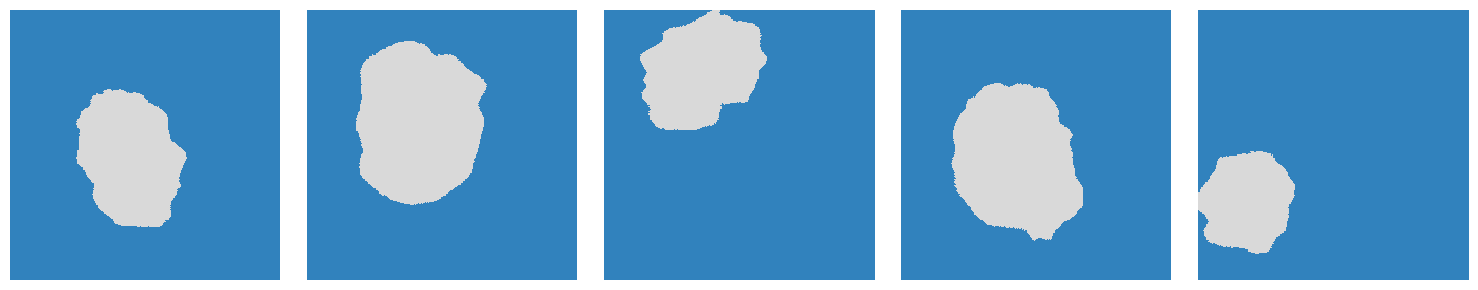

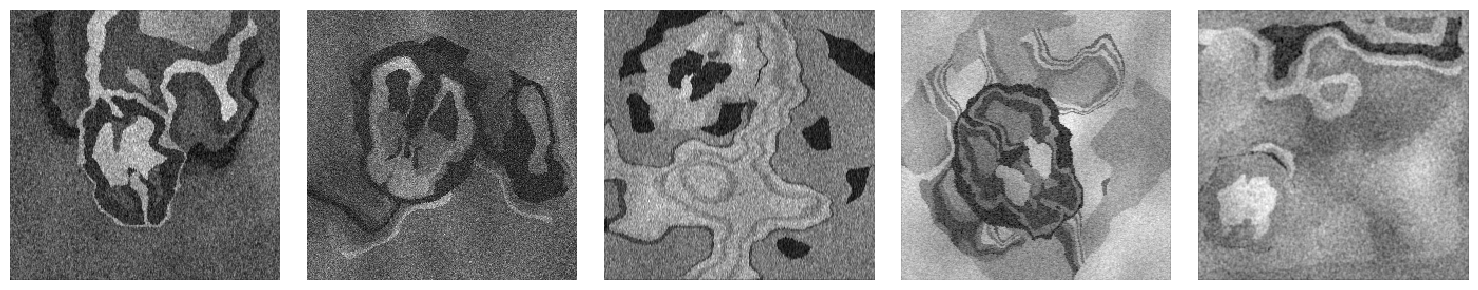

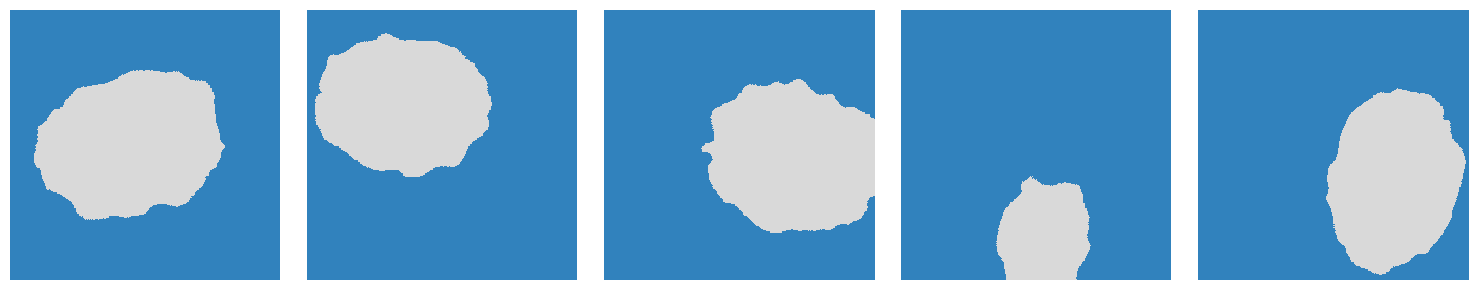

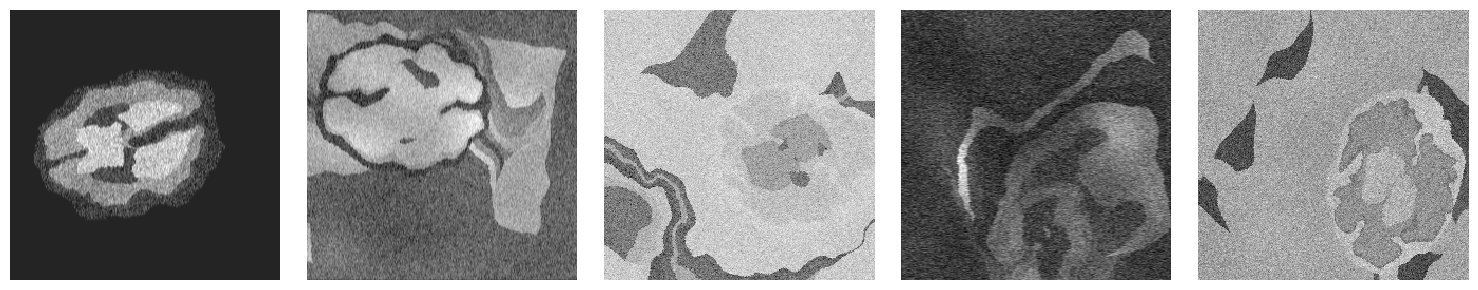

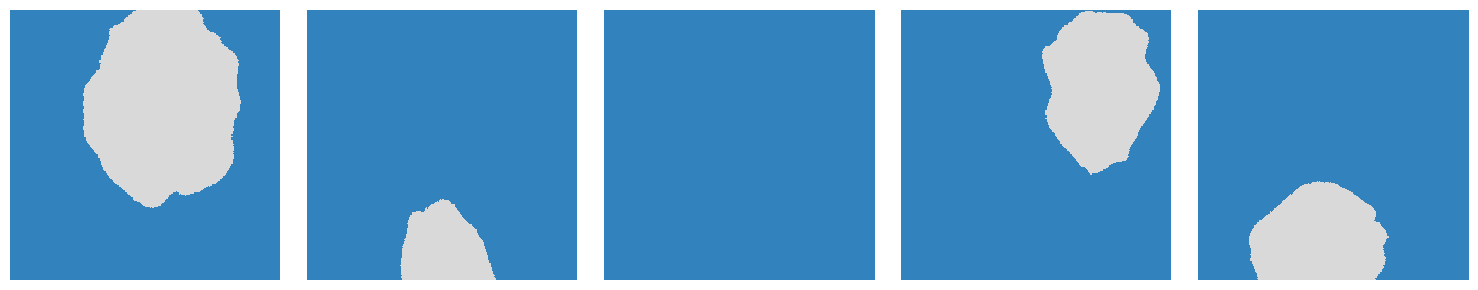

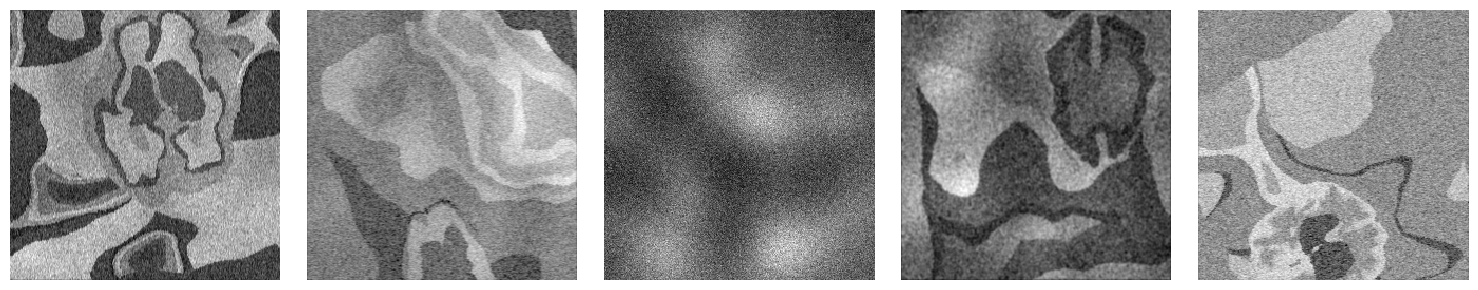

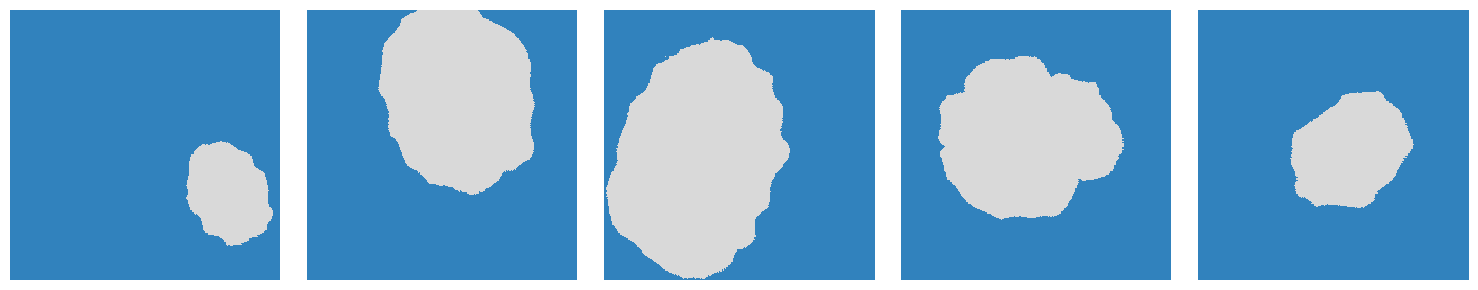

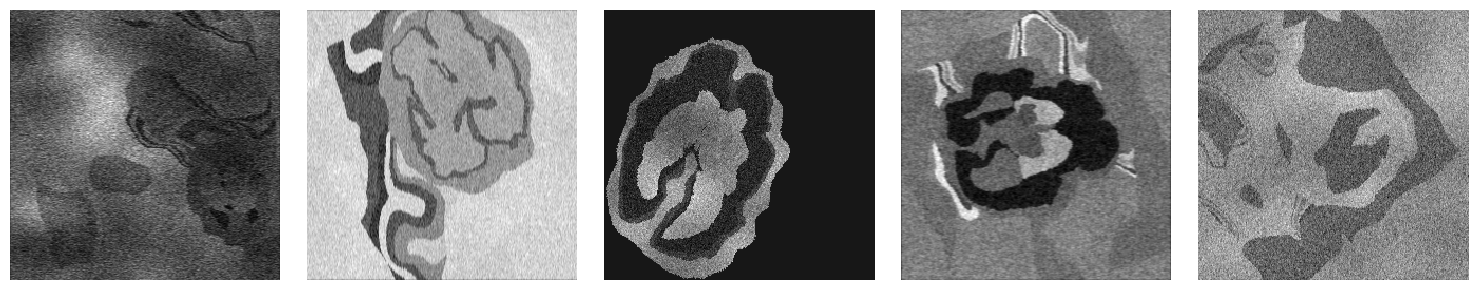

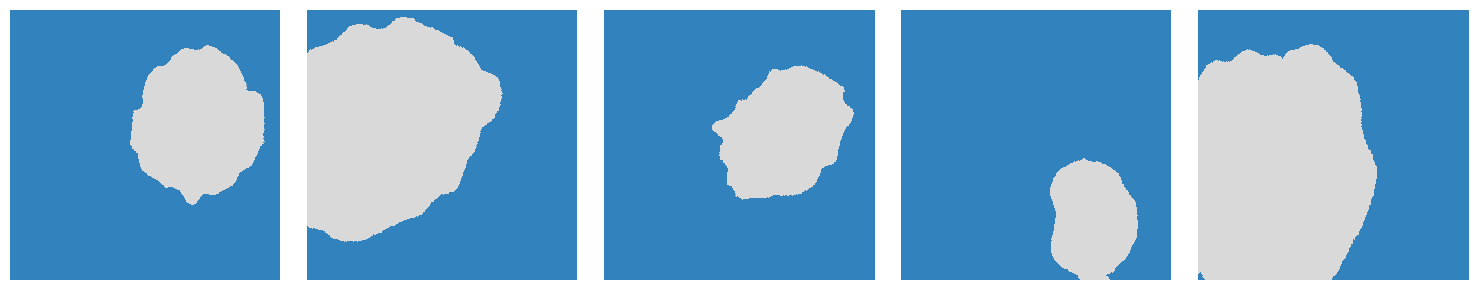

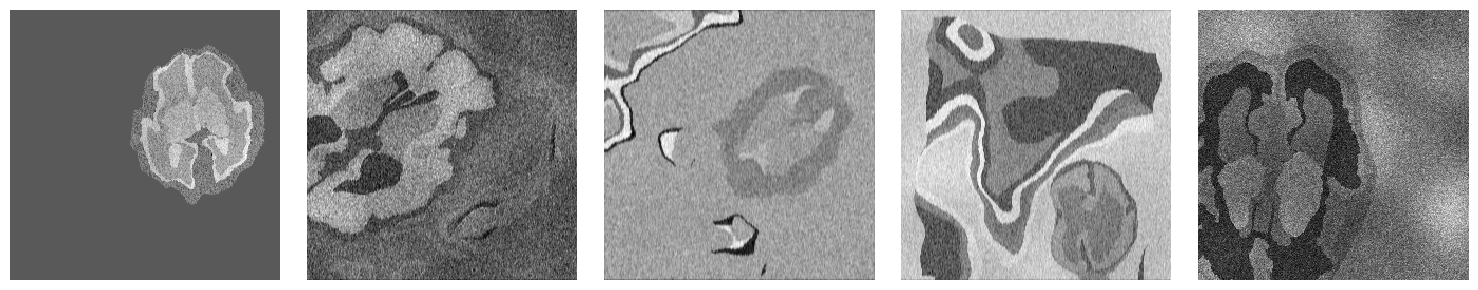

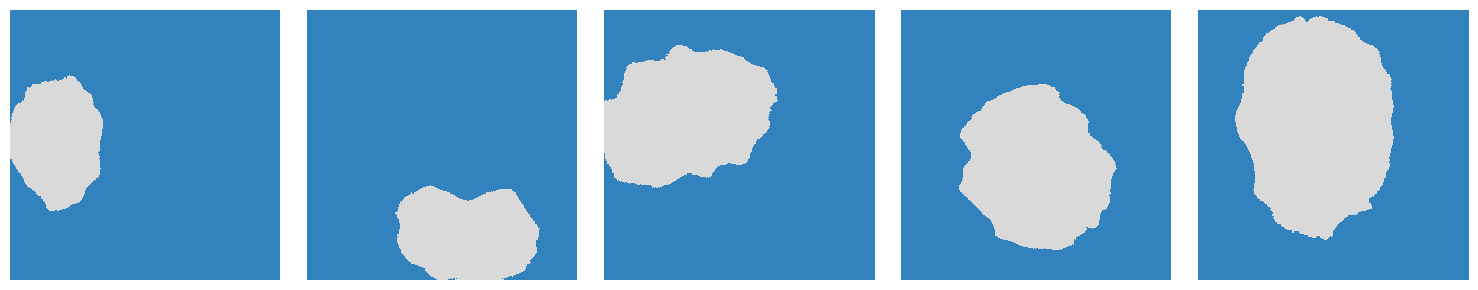

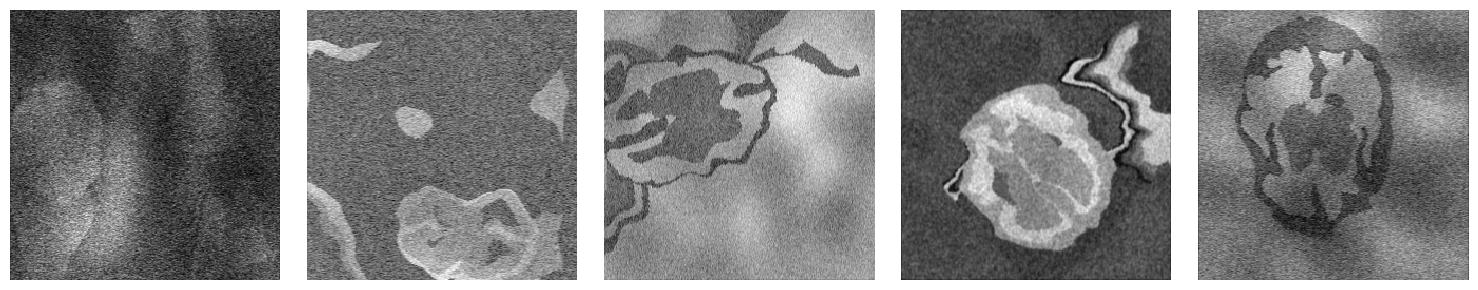

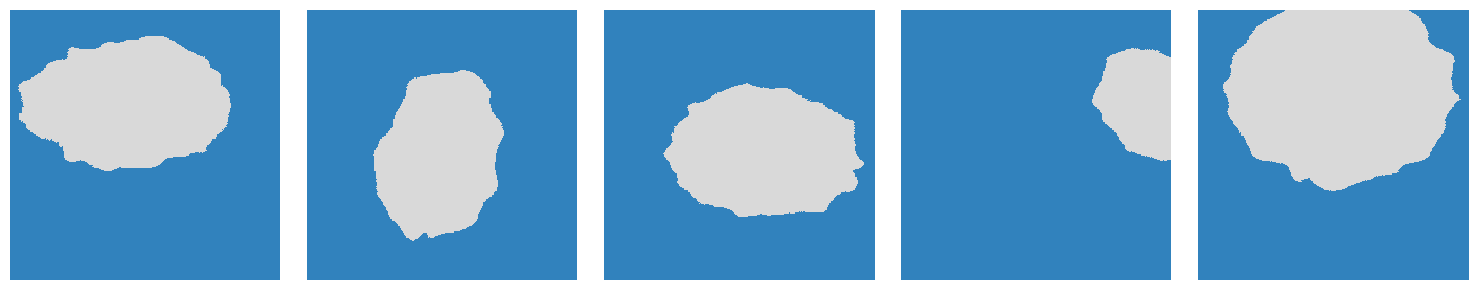

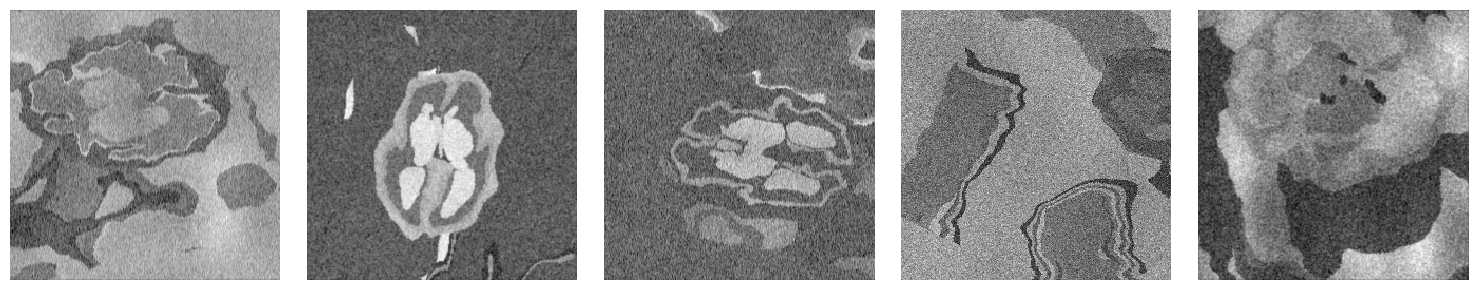

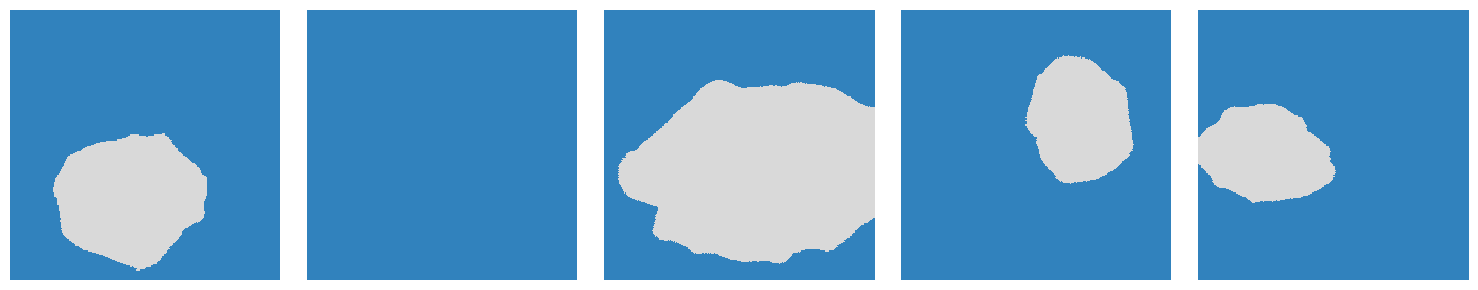

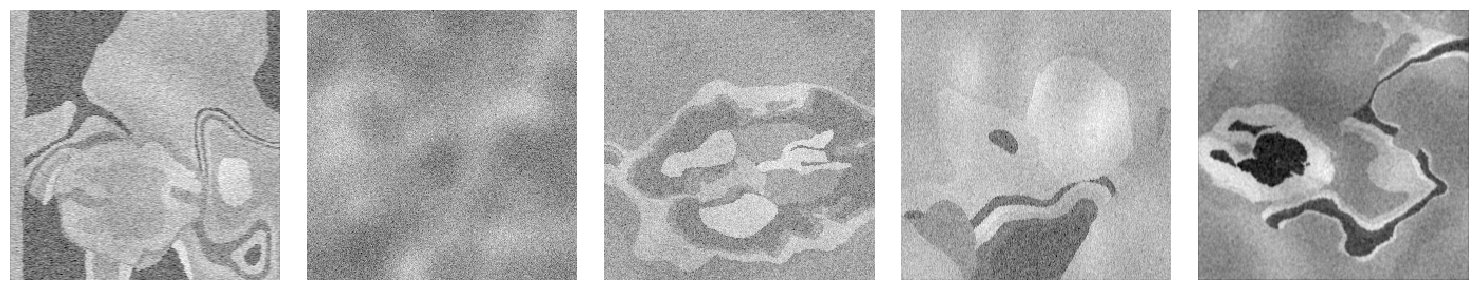

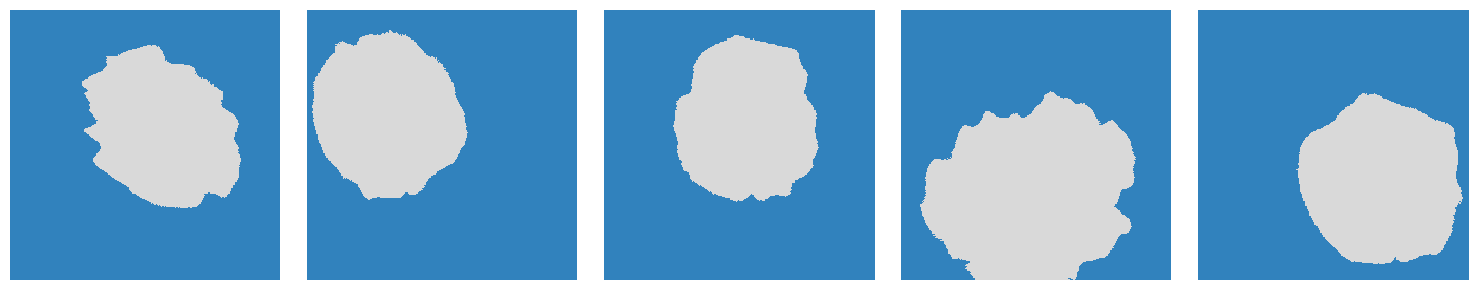

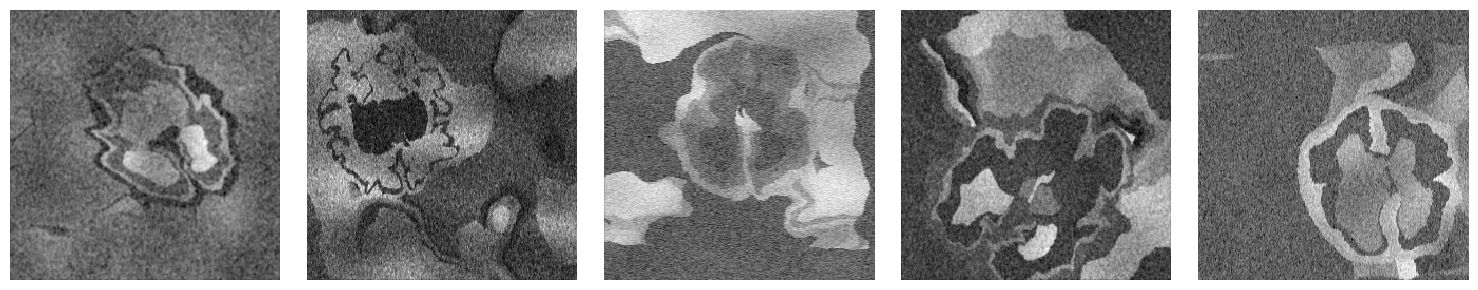

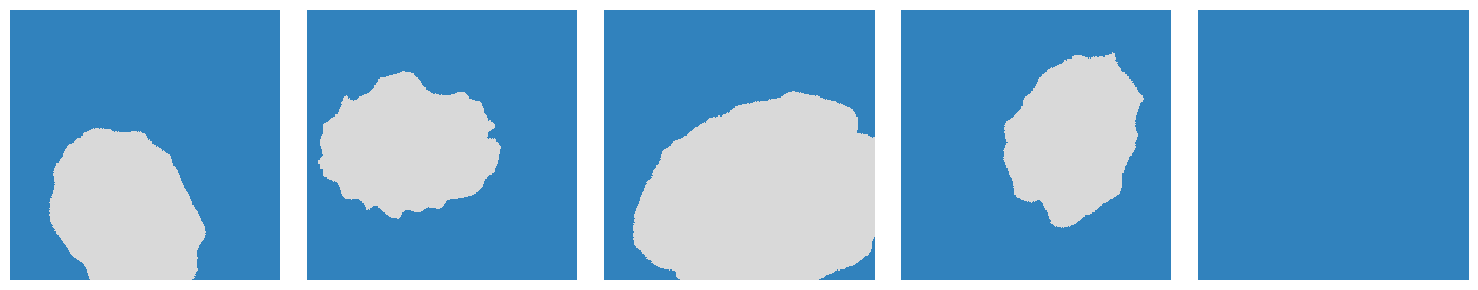

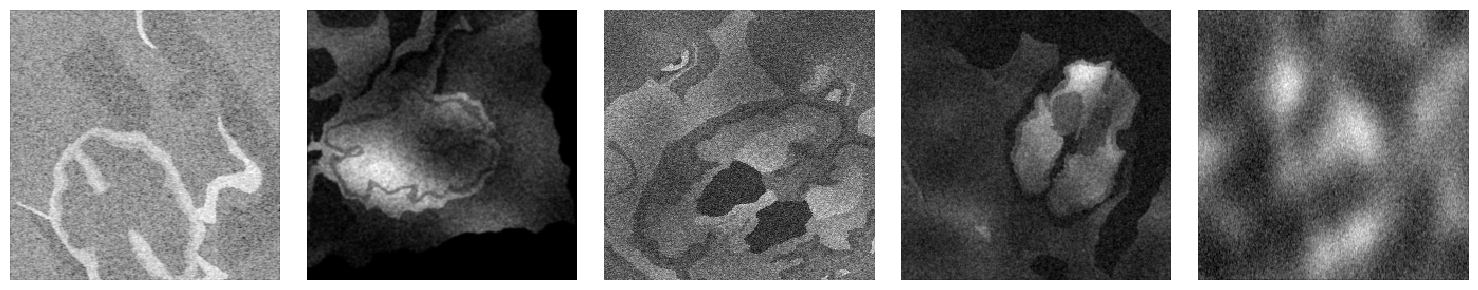

In [2]:
from tensorflow.keras.layers import Input, Lambda
import neurite as ne
import matplotlib.pyplot as plt

num_shapes = 50
combined_images=[]
combined_label_maps=[]
data_generator = my_generator(y_test, batch_size=1, same_subj=False, flip=False,**kwargs_shapes)
num_iterations = 50  # Set the number of iterations as needed

for i in range(num_iterations):
    gg, y = next(data_generator)
    combined_label_maps.append(gg)

num_rows = 10
num_cols = 5


combined_images = []
combined_maps=[]
for lm in combined_label_maps:
    lm = np.expand_dims(lm, axis=-1)
    model_1, label_map = labels_to_image_model.predict(lm)
    combined_maps.append(np.argmax(label_map, axis=-1))
    combined_images.append(np.squeeze(model_1, -1))   

maps_rows = [combined_maps[i:i+num_cols] for i in range(0, len(combined_maps), num_cols)]
image_rows = [combined_images[i:i+num_cols] for i in range(0, len(combined_images), num_cols)]

for i in range(len(maps_rows)):
    map_row = maps_rows[i]
    im_row = image_rows[i]

    fig1,ax1 = ne.plot.slices([list(shape) for shape in map_row], cmaps=['tab20c'] * num_cols)
    fig2, ax2 = ne.plot.slices([list(shape) for shape in im_row], cmaps=['gray'] * num_cols)


In [ ]:
unet_model = vxm.networks.Unet(inshape=(dimx, dimy, 1), nb_features=[[64,64,64,64,64], [64,64,64,64,64,2]], 
                               nb_conv_per_level=2,
                               final_activation_function=tf.nn.softmax)
unet_model.summary() 

labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)

input_img = Input(shape=(dimx, dimy))
generated_img, y = labels_to_image_model(input_img)
print(generated_img.shape,y.shape)

segmentation = unet_model(generated_img)
combined_model = Model(inputs=input_img, outputs=segmentation)
combined_model.add_loss(dice_loss(y, segmentation))
combined_model.compile(optimizer=Adam(learning_rate=initial_lr))
data_generator = my_generator(y_train, batch_size=batch_size, same_subj=False, flip=False,**kwargs_shapes)


print("here")
if os.path.exists(checkpoint_path):
    combined_model.load_weights(checkpoint_path)
    print("Loaded weights from the checkpoint and continued training.")
else:
    print("Checkpoint file not found.")
    
hist = combined_model.fit(
    data_generator,
    epochs=num_epochs,  # Set the total number of epochs including previous ones
    initial_epoch=0,  # Specify the initial epoch
    verbose=0,
    steps_per_epoch=5,
    callbacks=[weights_saver, TB_callback]
)

print(hist.history)
loss_history = hist.history['loss']
plt.plot(loss_history)
plt.title('Training Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# sys.stdout = original_stdout

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 unet_input (InputLayer)     [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 unet_enc_conv_0_0 (Conv2D)  (None, 256, 256, 64)         640       ['unet_input[0][0]']          
                                                                                                  
 unet_enc_conv_0_0_activati  (None, 256, 256, 64)         0         ['unet_enc_conv_0_0[0][0]']   
 on (LeakyReLU)                                                                                   
                                                                                                  
 unet_enc_conv_0_1 (Conv2D)  (None, 256, 256, 64)         36928     ['unet_enc_conv_0_0_activat

In [ ]:
# sys.stdout = original_stdout

# a = temp_lm[0:10]
for i in range(10):
    lm = temp_lm[i]
    lm = np.squeeze(lm[0],-1)#np.expand_dims(temp_lm[i], axis=-1)
    print(lm.shape)
    ne.plot.slices( lm,   cmaps=['tab20c'])# ne.plot.slices([list(image) for image in temp_lm], cmaps=['tab20c'] * len(temp_lm))


In [3]:
offset = kwargs_shapes.get('num_label', None)
print("ddd",offset)




ddd 16
